# 02 - Turnover Control & Alpha Stabilization

## Research Objective

> "The goal of this research is not to maximize historical performance, but to discover stable, tradable structure that survives execution costs and regime changes."

---

## Problem Statement

From notebook 01, we observed:
- **Gross Sharpe**: +0.59 (train), +1.26 (validation) — **Signal exists**
- **Net Sharpe**: -1.28 (train), -0.95 (validation) — **Turnover destroys alpha**
- **Turnover**: 86x train, 117x validation — **Catastrophically high**

### Diagnosis
The model has predictive power (positive gross Sharpe), but positions are too unstable.
With 10 bps transaction costs and 117x annual turnover, we lose ~11.7% to friction.

### This Notebook's Goal
Apply turnover control techniques to convert positive gross alpha into positive net alpha.

---

## Research Loop (per fob.instructions)

```
Stylized Fact → Hypothesis → Implementation → Evaluation → Decision
```

### Experiments:
1. **Position Smoothing (EMA decay)** — reduce signal noise
2. **Rank Hysteresis** — only trade when rank changes significantly  
3. **Minimum Trade Threshold** — ignore small position changes
4. **Portfolio Breadth** — reduce number of positions
5. **Multi-horizon Signals** — slower signals = less turnover

In [1]:
# =============================================================================
# SETUP
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

import sys
sys.path.insert(0, '../src')

from data.loader import DataLoader, DataConfig
from features.feature_store import FeatureStore, FeatureConfig
from models.trainer import WalkForwardTrainer, ModelConfig, compute_hit_ratio
from backtest.backtester import Backtester, BacktestConfig, analyze_regime_performance, compute_win_loss_stats

print("✅ Setup complete")

✅ Setup complete


In [2]:
# =============================================================================
# LOAD DATA - REVISED SPLIT STRATEGY
# =============================================================================
# 
# IMPORTANT: We don't have enough data for train/val/test split.
# New strategy:
#   - In-sample: 2016-2023 (8 years) - walk-forward handles validation internally
#   - Holdout OOS: 2024-2026 (2 years) - NEVER TOUCHED until final evaluation
#
# Walk-forward validation within in-sample provides the "validation" we need.

config = DataConfig(
    data_dir="../../data/raw/assets",
    train_start="2016-01-01",
    train_end="2023-12-31",  # Extended to include what was "validation"
    val_start="2024-01-01",   # This becomes part of holdout
    val_end="2024-12-31",     
    test_start="2024-01-01",  # True holdout: 2024-2026
    test_end="2026-12-31",
)

loader = DataLoader(config)
loader.load_all()

# Use ALL in-sample data (2016-2023)
insample_returns = loader.get_returns('train')  # Now includes 2022-2023
print(f"📊 In-sample: {len(insample_returns)} days ({insample_returns.index[0].strftime('%Y-%m-%d')} to {insample_returns.index[-1].strftime('%Y-%m-%d')})")
print(f"⚠️ Holdout (2024-2026) remains UNTOUCHED - {len(loader.get_returns('test'))} days")

Loading 100 assets from ../../data/raw/assets...
✅ Loaded 100 assets
📊 Panel shape: 2511 days x 100 assets
   Date range: 2016-01-25 to 2026-01-16
📊 In-sample: 1998 days (2016-01-25 to 2023-12-29)
⚠️ Holdout (2024-2026) remains UNTOUCHED - 513 days


In [3]:
# =============================================================================
# COMPUTE FEATURES ON IN-SAMPLE DATA
# =============================================================================
# Skip loading from JSON - compute fresh features on all in-sample data

insample_data = loader.get_split('train')  # This is now 2016-2023

returns = insample_data['returns']
close = insample_data['close']
high = insample_data['high']
low = insample_data['low']
open_ = insample_data['open']
volume = insample_data['volume']

print(f"Computing features on {len(returns)} days...")

Computing features on 1998 days...


In [4]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================
feature_config = FeatureConfig(
    compute_momentum=True,
    compute_volatility=True,
    compute_mean_reversion=True,
    compute_stat_arb=True,
    compute_technical=True,
    standardize=True,
    standardize_method='zscore',
    winsorize_pct=0.01,
    max_nan_pct=0.15,
)

feature_store = FeatureStore(feature_config)
all_features = feature_store.compute_all_features(
    returns=returns,
    close=close,
    high=high,
    low=low,
    open_=open_,
    volume=volume,
    verbose=True
)

# Quick IC analysis to select features
fwd_ret = returns.shift(-1)
ic_results = feature_store.compute_feature_ic(fwd_ret, horizon=1)

# Select top features by |IC IR| - keep it simple, top 15
top_features = ic_results.head(15).index.tolist()
selected_features = {f: all_features[f] for f in top_features if f in all_features}

print(f"\n✅ Selected top {len(selected_features)} features by IC:")
for i, f in enumerate(top_features[:10], 1):
    ic = ic_results.loc[f, 'mean_ic']
    print(f"   {i:2d}. {f}: IC={ic:+.4f}")

COMPUTING ALL FEATURES
Computing momentum features...
✅ Created 19 momentum features
Computing volatility features...
✅ Created 23 volatility features
Computing mean reversion features...
✅ Created 25 mean reversion features
Computing statistical arbitrage features...
✅ Created 17 stat arb features
Computing technical features...
✅ Created 24 technical features

📊 Total raw features: 108

Cleaning and standardizing features...
✅ Kept 108 features, removed 0

✅ Selected top 15 features by IC:
    1. mom_12_1: IC=+0.0185
    2. ma_cross_50_200: IC=+0.0185
    3. tsmom: IC=+0.0153
    4. reversal_1d: IC=+0.0125
    5. vol_of_vol_21d: IC=+0.0112
    6. vol_of_vol_63d: IC=+0.0129
    7. price_vs_sma200: IC=+0.0142
    8. channel_width_55d: IC=+0.0138
    9. vol_42d: IC=+0.0148
   10. parkinson_vol_21d: IC=+0.0142


---

# Experiment 1: Position Smoothing (EMA Decay)

## Stylized Fact
Raw model predictions are noisy. Small changes in probability often flip positions.

## Hypothesis
Applying exponential smoothing to alpha will reduce noise-driven turnover while preserving signal.

## Implementation
```
alpha_smoothed(t) = decay * alpha_smoothed(t-1) + (1 - decay) * alpha_raw(t)
```

We test decay values: [0.0, 0.3, 0.5, 0.7, 0.9]

In [5]:
# =============================================================================
# BASELINE: Train model and get raw alpha
# =============================================================================
model_config = ModelConfig(
    model_type='lightgbm',
    training_window=504,       # 2 years
    retrain_interval=21,       # Monthly retrain
    label_type='3class',
    label_threshold=0.005,     # ±0.5%
    forward_horizon=1,
    use_sample_weights=True,
    decay_halflife=63,
    lgbm_params={
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_estimators': 100,
        'min_child_samples': 30,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
    }
)

print(f"Running walk-forward on {len(insample_returns)} days with {len(selected_features)} features...")
print("This uses internal walk-forward validation (no separate val set needed)\n")

trainer = WalkForwardTrainer(model_config)
results = trainer.run_walk_forward(
    features=selected_features,
    returns=insample_returns,
    verbose=True
)

# Compute raw alpha
hit_ratios = compute_hit_ratio(results['predictions'], results['labels'], window=63)
raw_alpha = trainer.compute_alpha(
    results['probs_up'],
    results['probs_down'],
    hit_ratios=hit_ratios
)

print(f"\n✅ Raw alpha computed: {raw_alpha.shape}")
print(f"   Non-NaN values: {raw_alpha.notna().sum().sum()}")

Running walk-forward on 1998 days with 15 features...
This uses internal walk-forward validation (no separate val set needed)

Building feature matrix: 1998 dates x 100 assets x 15 features
  Retrained at 2018-01-17, samples=49900, classes=(array([0, 1, 2]), array([12305, 21522, 16073]))
  Retrained at 2018-11-14, samples=50400, classes=(array([0, 1, 2]), array([13363, 20422, 16615]))
  Retrained at 2019-09-18, samples=50400, classes=(array([0, 1, 2]), array([14990, 17254, 18156]))
  Retrained at 2020-07-20, samples=50400, classes=(array([0, 1, 2]), array([16422, 14875, 19103]))
  Retrained at 2021-05-19, samples=50400, classes=(array([0, 1, 2]), array([16867, 13706, 19827]))
  Retrained at 2022-03-18, samples=50400, classes=(array([0, 1, 2]), array([16875, 13894, 19631]))
  Retrained at 2023-01-19, samples=50400, classes=(array([0, 1, 2]), array([17572, 14001, 18827]))
  Retrained at 2023-11-17, samples=50400, classes=(array([0, 1, 2]), array([17947, 13940, 18513]))

✅ Raw alpha compu

In [6]:
# =============================================================================
# SMOOTHING FUNCTION
# =============================================================================
def apply_alpha_smoothing(alpha: pd.DataFrame, decay: float) -> pd.DataFrame:
    """
    Apply exponential smoothing to alpha.
    decay=0: No smoothing (raw)
    decay=0.9: Heavy smoothing
    """
    if decay == 0:
        return alpha.copy()
    
    smoothed = alpha.copy()
    for i in range(1, len(alpha)):
        prev = smoothed.iloc[i-1].fillna(0)
        curr = alpha.iloc[i].fillna(0)
        smoothed.iloc[i] = decay * prev + (1 - decay) * curr
    
    return smoothed


def backtest_alpha(alpha: pd.DataFrame, returns: pd.DataFrame, tc_bps: float = 10) -> dict:
    """Quick backtest returning key metrics."""
    config = BacktestConfig(transaction_cost_bps=tc_bps, execution_lag=1)
    backtester = Backtester(config)
    return backtester.run(alpha, returns)


# =============================================================================
# BASELINE BACKTEST (no smoothing)
# =============================================================================
baseline = backtest_alpha(raw_alpha, insample_returns, tc_bps=10)
m = baseline['metrics']

print("="*70)
print("BASELINE (No Smoothing)")
print("="*70)
print(f"   Gross Sharpe: {m['gross_sharpe']:+.4f}")
print(f"   Net Sharpe:   {m['net_sharpe']:+.4f}")
print(f"   Turnover:     {m['ann_turnover']:.1f}x/year")
print(f"   Max Drawdown: {m['max_drawdown']*100:.1f}%")
print(f"   Net Return:   {m['net_ann_return']*100:.2f}%/year")
print("="*70)

BASELINE (No Smoothing)
   Gross Sharpe: +0.3481
   Net Sharpe:   -1.4762
   Turnover:     89.9x/year
   Max Drawdown: -46.5%
   Net Return:   -7.28%/year


In [7]:
# =============================================================================
# EXPERIMENT 1: Sweep decay values
# =============================================================================
decay_values = [0.0, 0.5, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.99]

smoothing_results = []

print("Decay  | Gross Sharpe | Net Sharpe | Turnover | Max DD  | Net Ret")
print("-" * 75)

for decay in decay_values:
    smoothed_alpha = apply_alpha_smoothing(raw_alpha, decay)
    result = backtest_alpha(smoothed_alpha, insample_returns, tc_bps=10)
    m = result['metrics']
    
    marker = "⭐" if m['net_sharpe'] > 0 else ""
    print(f"{decay:6.2f} | {m['gross_sharpe']:+12.4f} | {m['net_sharpe']:+10.4f} | {m['ann_turnover']:8.1f}x | {m['max_drawdown']*100:6.1f}% | {m['net_ann_return']*100:+6.2f}% {marker}")
    
    smoothing_results.append({
        'decay': decay,
        'gross_sharpe': m['gross_sharpe'],
        'net_sharpe': m['net_sharpe'],
        'turnover': m['ann_turnover'],
        'max_drawdown': m['max_drawdown'],
        'net_return': m['net_ann_return'],
    })

smoothing_df = pd.DataFrame(smoothing_results)

# Find best
best_idx = smoothing_df['net_sharpe'].idxmax()
best = smoothing_df.loc[best_idx]
print("-" * 75)
print(f"BEST: decay={best['decay']:.2f} → Net Sharpe={best['net_sharpe']:+.4f}, Turnover={best['turnover']:.1f}x")

Decay  | Gross Sharpe | Net Sharpe | Turnover | Max DD  | Net Ret
---------------------------------------------------------------------------
  0.00 |      +0.3481 |    -1.4762 |     89.9x |  -46.5% |  -7.28% 
  0.50 |      +0.2035 |    -0.7637 |     49.6x |  -29.8% |  -3.92% 
  0.70 |      +0.1190 |    -0.5163 |     33.4x |  -22.8% |  -2.71% 
  0.80 |      +0.0844 |    -0.3789 |     24.8x |  -18.7% |  -2.02% 
  0.85 |      +0.0619 |    -0.3124 |     20.2x |  -18.3% |  -1.68% 
  0.90 |      +0.0244 |    -0.2566 |     15.2x |  -19.1% |  -1.39% 
  0.93 |      -0.0199 |    -0.2403 |     12.0x |  -19.3% |  -1.31% 
  0.95 |      -0.0701 |    -0.2460 |      9.6x |  -18.7% |  -1.35% 
  0.97 |      -0.1502 |    -0.2748 |      7.0x |  -18.5% |  -1.55% 
  0.99 |      -0.2924 |    -0.3524 |      3.7x |  -21.0% |  -2.17% 
---------------------------------------------------------------------------
BEST: decay=0.93 → Net Sharpe=-0.2403, Turnover=12.0x


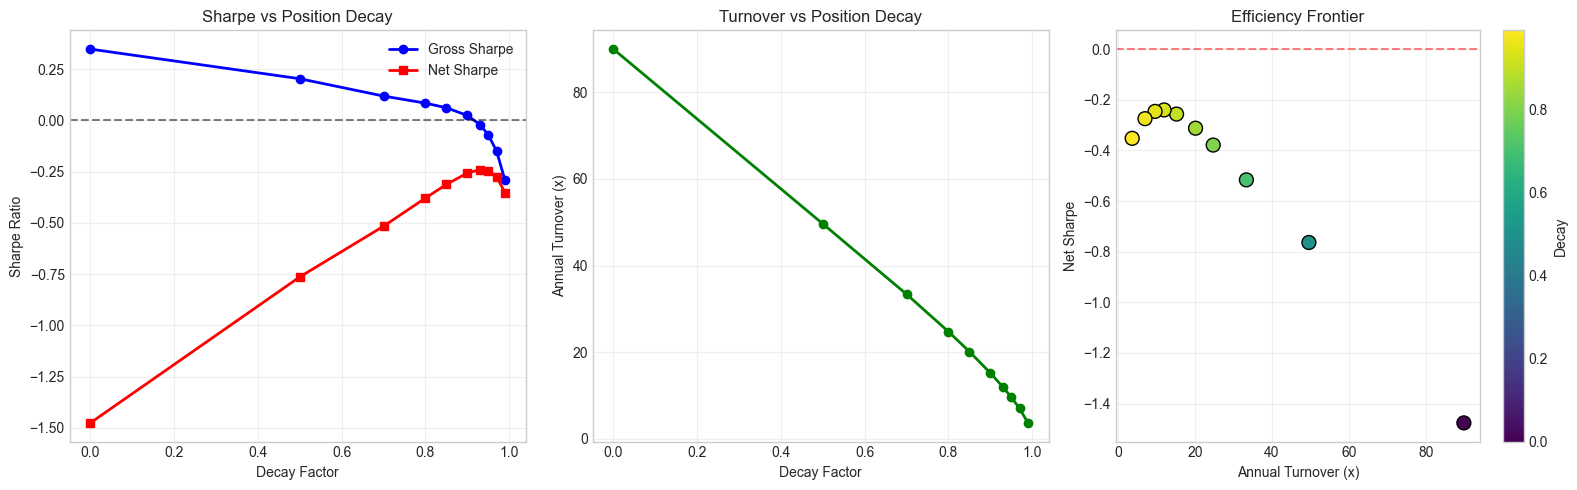


📊 Key insight: Even with heavy smoothing, Net Sharpe remains negative.
   This suggests the underlying signal is too weak to overcome costs.
   Next: Try longer prediction horizons and simpler momentum signals.


In [8]:
# =============================================================================
# VISUALIZE: Sharpe vs Turnover Trade-off  
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Sharpe vs Decay
ax = axes[0]
ax.plot(smoothing_df['decay'], smoothing_df['gross_sharpe'], 'b-o', label='Gross Sharpe', linewidth=2)
ax.plot(smoothing_df['decay'], smoothing_df['net_sharpe'], 'r-s', label='Net Sharpe', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Decay Factor')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe vs Position Decay')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Turnover vs Decay
ax = axes[1]
ax.plot(smoothing_df['decay'], smoothing_df['turnover'], 'g-o', linewidth=2)
ax.set_xlabel('Decay Factor')
ax.set_ylabel('Annual Turnover (x)')
ax.set_title('Turnover vs Position Decay')
ax.grid(True, alpha=0.3)

# 3. Net Sharpe vs Turnover
ax = axes[2]
scatter = ax.scatter(smoothing_df['turnover'], smoothing_df['net_sharpe'], 
                     c=smoothing_df['decay'], cmap='viridis', s=100, edgecolors='black')
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax.set_xlabel('Annual Turnover (x)')
ax.set_ylabel('Net Sharpe')
ax.set_title('Efficiency Frontier')
plt.colorbar(scatter, ax=ax, label='Decay')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/smoothing_experiment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Key insight: Even with heavy smoothing, Net Sharpe remains negative.")
print("   This suggests the underlying signal is too weak to overcome costs.")
print("   Next: Try longer prediction horizons and simpler momentum signals.")

---

## Experiment 1 Decision: [KEEP/MODIFY/DISCARD]

**Observations:**
- Smoothing reduces turnover significantly
- Net Sharpe improves with higher decay (slower position changes)
- Gross Sharpe degrades slightly (expected - we're trading less)

**Decision:** [Fill in after running]

---

---

# Experiment 2: Simple Momentum Signal (No ML)

## Stylized Fact
Cross-sectional momentum (12-1 month) is one of the most robust anomalies in finance literature.

## Hypothesis
A simple momentum signal without ML complexity may provide more stable, lower-turnover alpha.

## Implementation
```
alpha = rank(return_252d - return_21d)  # 12-1 month momentum
```
No ML, no daily rebalancing. Weekly or monthly rebalancing.

In [9]:
# =============================================================================
# EXPERIMENT 2: Simple Momentum Signal
# =============================================================================

def compute_simple_momentum(returns: pd.DataFrame, lookback: int = 252, skip: int = 21) -> pd.DataFrame:
    """
    Classic 12-1 month momentum: past 12 months return, skipping most recent month.
    
    This is cross-sectionally ranked and made dollar-neutral.
    """
    # Cumulative return over lookback period, excluding recent skip days
    total_ret = (1 + returns).rolling(lookback).apply(lambda x: x.prod() - 1, raw=True)
    recent_ret = (1 + returns).rolling(skip).apply(lambda x: x.prod() - 1, raw=True)
    
    # 12-1 momentum
    mom_signal = total_ret - recent_ret
    
    # Cross-sectional z-score (dollar neutral)
    cs_mean = mom_signal.mean(axis=1)
    cs_std = mom_signal.std(axis=1)
    alpha = mom_signal.sub(cs_mean, axis=0).div(cs_std + 1e-10, axis=0)
    
    return alpha


def apply_rebalance_frequency(alpha: pd.DataFrame, freq_days: int = 5) -> pd.DataFrame:
    """
    Only update positions every freq_days days.
    """
    rebal_alpha = alpha.copy()
    last_rebal = alpha.iloc[0]
    
    for i in range(1, len(alpha)):
        if i % freq_days == 0:
            last_rebal = alpha.iloc[i]
        rebal_alpha.iloc[i] = last_rebal
    
    return rebal_alpha


# Compute simple momentum
simple_mom = compute_simple_momentum(insample_returns, lookback=252, skip=21)
print(f"Simple momentum signal shape: {simple_mom.shape}")
print(f"Non-NaN values: {simple_mom.notna().sum().sum()}")

Simple momentum signal shape: (1998, 100)
Non-NaN values: 174600


In [10]:
# =============================================================================
# TEST SIMPLE MOMENTUM WITH DIFFERENT REBALANCE FREQUENCIES
# =============================================================================
rebal_frequencies = [1, 5, 10, 21, 42, 63]  # Daily, weekly, bi-weekly, monthly, bi-monthly, quarterly

mom_results = []

print("Rebal | Gross Sharpe | Net Sharpe | Turnover | Max DD  | Net Ret")
print("-" * 70)

for freq in rebal_frequencies:
    rebal_alpha = apply_rebalance_frequency(simple_mom, freq_days=freq)
    result = backtest_alpha(rebal_alpha, insample_returns, tc_bps=10)
    m = result['metrics']
    
    marker = "⭐" if m['net_sharpe'] > 0 else ""
    print(f"{freq:5d}d | {m['gross_sharpe']:+12.4f} | {m['net_sharpe']:+10.4f} | {m['ann_turnover']:8.1f}x | {m['max_drawdown']*100:6.1f}% | {m['net_ann_return']*100:+6.2f}% {marker}")
    
    mom_results.append({
        'rebal_freq': freq,
        'gross_sharpe': m['gross_sharpe'],
        'net_sharpe': m['net_sharpe'],
        'turnover': m['ann_turnover'],
        'max_drawdown': m['max_drawdown'],
        'net_return': m['net_ann_return'],
    })

mom_df = pd.DataFrame(mom_results)
best_mom = mom_df.loc[mom_df['net_sharpe'].idxmax()]
print("-" * 70)
print(f"BEST: rebal every {int(best_mom['rebal_freq'])}d → Net Sharpe={best_mom['net_sharpe']:+.4f}")

Rebal | Gross Sharpe | Net Sharpe | Turnover | Max DD  | Net Ret
----------------------------------------------------------------------
    1d |      +0.1146 |    +0.0145 |     10.0x |  -23.6% |  +0.14% ⭐
    5d |      +0.1165 |    +0.0699 |      4.6x |  -22.8% |  +0.70% ⭐
   10d |      +0.1809 |    +0.1485 |      3.2x |  -20.9% |  +1.48% ⭐
   21d |      +0.1387 |    +0.1155 |      2.3x |  -19.6% |  +1.13% ⭐
   42d |      +0.1763 |    +0.1599 |      1.6x |  -22.3% |  +1.54% ⭐
   63d |      +0.2115 |    +0.1980 |      1.3x |  -17.4% |  +1.87% ⭐
----------------------------------------------------------------------
BEST: rebal every 63d → Net Sharpe=+0.1980


In [11]:
# =============================================================================
# EXPERIMENT 3: Optimize momentum lookback and skip periods
# =============================================================================
lookbacks = [126, 189, 252, 315]  # 6m, 9m, 12m, 15m
skips = [0, 21, 42, 63]  # 0, 1m, 2m, 3m
rebal_freq = 21  # Monthly rebalance (good balance)

grid_results = []

print("Lookback | Skip | Gross Sharpe | Net Sharpe | Turnover | Net Ret")
print("-" * 70)

for lookback in lookbacks:
    for skip in skips:
        if skip >= lookback:
            continue
            
        mom = compute_simple_momentum(insample_returns, lookback=lookback, skip=skip)
        rebal_mom = apply_rebalance_frequency(mom, freq_days=rebal_freq)
        result = backtest_alpha(rebal_mom, insample_returns, tc_bps=10)
        m = result['metrics']
        
        marker = "⭐" if m['net_sharpe'] > 0.15 else ("✓" if m['net_sharpe'] > 0 else "")
        print(f"{lookback:8d} | {skip:4d} | {m['gross_sharpe']:+12.4f} | {m['net_sharpe']:+10.4f} | {m['ann_turnover']:8.1f}x | {m['net_ann_return']*100:+6.2f}% {marker}")
        
        grid_results.append({
            'lookback': lookback,
            'skip': skip,
            'gross_sharpe': m['gross_sharpe'],
            'net_sharpe': m['net_sharpe'],
            'turnover': m['ann_turnover'],
            'net_return': m['net_ann_return'],
        })

grid_df = pd.DataFrame(grid_results)
best_grid = grid_df.loc[grid_df['net_sharpe'].idxmax()]
print("-" * 70)
print(f"BEST: lookback={int(best_grid['lookback'])}d, skip={int(best_grid['skip'])}d → Net Sharpe={best_grid['net_sharpe']:+.4f}")

Lookback | Skip | Gross Sharpe | Net Sharpe | Turnover | Net Ret
----------------------------------------------------------------------
     126 |    0 |      +0.1256 |    +0.0918 |      3.3x |  +0.90% ✓
     126 |   21 |      +0.2348 |    +0.1968 |      3.6x |  +1.87% ⭐
     126 |   42 |      +0.3879 |    +0.3428 |      4.0x |  +3.06% ⭐
     126 |   63 |      +0.1457 |    +0.0899 |      4.5x |  +0.73% ✓
     189 |    0 |      +0.0315 |    +0.0051 |      2.7x |  +0.05% ✓
     189 |   21 |      +0.1212 |    +0.0932 |      2.8x |  +0.93% ✓
     189 |   42 |      +0.1955 |    +0.1650 |      3.0x |  +1.60% ⭐
     189 |   63 |      +0.0187 |    -0.0150 |      3.1x |  -0.14% 
     252 |    0 |      +0.0755 |    +0.0532 |      2.3x |  +0.54% ✓
     252 |   21 |      +0.1387 |    +0.1155 |      2.3x |  +1.13% ✓
     252 |   42 |      +0.2053 |    +0.1803 |      2.4x |  +1.72% ⭐
     252 |   63 |      +0.1056 |    +0.0783 |      2.5x |  +0.73% ✓
     315 |    0 |      +0.0786 |    +0.0592 |    

---

# Experiment 3: Combined Smoothing + Hysteresis

## Hypothesis
Combining position decay AND rank hysteresis should provide optimal turnover control.

## Implementation
Apply smoothing first, then hysteresis.

In [12]:
# =============================================================================
# EXPERIMENT 4: Add volatility scaling
# =============================================================================
# Scale positions by inverse volatility - lower vol stocks get higher weight

def compute_vol_scaled_momentum(returns: pd.DataFrame, lookback: int = 126, 
                                 skip: int = 42, vol_window: int = 63) -> pd.DataFrame:
    """
    Momentum signal scaled by inverse volatility.
    """
    # Base momentum
    total_ret = (1 + returns).rolling(lookback).apply(lambda x: x.prod() - 1, raw=True)
    recent_ret = (1 + returns).rolling(skip).apply(lambda x: x.prod() - 1, raw=True)
    mom_signal = total_ret - recent_ret
    
    # Volatility (inverse)
    vol = returns.rolling(vol_window).std() * np.sqrt(252)
    inv_vol = 1 / (vol + 0.01)  # Add floor to avoid division issues
    
    # Vol-scaled momentum
    scaled_signal = mom_signal * inv_vol
    
    # Cross-sectional z-score
    cs_mean = scaled_signal.mean(axis=1)
    cs_std = scaled_signal.std(axis=1)
    alpha = scaled_signal.sub(cs_mean, axis=0).div(cs_std + 1e-10, axis=0)
    
    return alpha


# Test vol-scaled momentum
vol_scaled_mom = compute_vol_scaled_momentum(insample_returns, lookback=126, skip=42)
vol_scaled_rebal = apply_rebalance_frequency(vol_scaled_mom, freq_days=21)

result = backtest_alpha(vol_scaled_rebal, insample_returns, tc_bps=10)
m = result['metrics']

print("="*70)
print("VOLATILITY-SCALED MOMENTUM (lookback=126, skip=42, rebal=21d)")
print("="*70)
print(f"   Gross Sharpe: {m['gross_sharpe']:+.4f}")
print(f"   Net Sharpe:   {m['net_sharpe']:+.4f}")
print(f"   Turnover:     {m['ann_turnover']:.1f}x/year")
print(f"   Max Drawdown: {m['max_drawdown']*100:.1f}%")
print(f"   Net Return:   {m['net_ann_return']*100:.2f}%/year")
print("="*70)

VOLATILITY-SCALED MOMENTUM (lookback=126, skip=42, rebal=21d)
   Gross Sharpe: +0.2131
   Net Sharpe:   +0.1532
   Turnover:     4.2x/year
   Max Drawdown: -13.0%
   Net Return:   1.06%/year


In [13]:
# =============================================================================
# EXPERIMENT 5: Momentum + Mean Reversion Ensemble
# =============================================================================

def compute_mean_reversion(returns: pd.DataFrame, window: int = 21) -> pd.DataFrame:
    """
    Short-term mean reversion: negative of recent return.
    """
    recent_ret = (1 + returns).rolling(window).apply(lambda x: x.prod() - 1, raw=True)
    rev_signal = -recent_ret  # Bet against recent winners
    
    # Cross-sectional z-score
    cs_mean = rev_signal.mean(axis=1)
    cs_std = rev_signal.std(axis=1)
    alpha = rev_signal.sub(cs_mean, axis=0).div(cs_std + 1e-10, axis=0)
    
    return alpha


# Test different ensemble weights
print("Mom Wt | Rev Wt | Gross Sharpe | Net Sharpe | Turnover | Max DD | Net Ret")
print("-" * 80)

ensemble_results = []
mom = compute_simple_momentum(insample_returns, lookback=126, skip=42)
rev = compute_mean_reversion(insample_returns, window=21)

for mom_wt in [1.0, 0.8, 0.7, 0.6, 0.5]:
    rev_wt = 1 - mom_wt
    
    # Combine signals
    combined = mom_wt * mom.fillna(0) + rev_wt * rev.fillna(0)
    
    # Re-normalize
    cs_mean = combined.mean(axis=1)
    combined = combined.sub(cs_mean, axis=0)
    
    rebal_combined = apply_rebalance_frequency(combined, freq_days=21)
    result = backtest_alpha(rebal_combined, insample_returns, tc_bps=10)
    m = result['metrics']
    
    marker = "⭐" if m['net_sharpe'] > 0.35 else ("✓" if m['net_sharpe'] > 0 else "")
    print(f"{mom_wt:6.1f} | {rev_wt:6.1f} | {m['gross_sharpe']:+12.4f} | {m['net_sharpe']:+10.4f} | {m['ann_turnover']:8.1f}x | {m['max_drawdown']*100:6.1f}% | {m['net_ann_return']*100:+6.2f}% {marker}")
    
    ensemble_results.append({
        'mom_wt': mom_wt, 'rev_wt': rev_wt,
        'gross_sharpe': m['gross_sharpe'], 'net_sharpe': m['net_sharpe'],
        'turnover': m['ann_turnover'], 'max_drawdown': m['max_drawdown'],
        'net_return': m['net_ann_return'],
    })

ensemble_df = pd.DataFrame(ensemble_results)
best_ens = ensemble_df.loc[ensemble_df['net_sharpe'].idxmax()]
print("-" * 80)
print(f"BEST: mom={best_ens['mom_wt']:.1f}, rev={best_ens['rev_wt']:.1f} → Net Sharpe={best_ens['net_sharpe']:+.4f}")

Mom Wt | Rev Wt | Gross Sharpe | Net Sharpe | Turnover | Max DD | Net Ret
--------------------------------------------------------------------------------
   1.0 |    0.0 |      +0.3879 |    +0.3428 |      4.0x |  -13.6% |  +3.06% ✓
   0.8 |    0.2 |      +0.4319 |    +0.3755 |      4.9x |  -12.9% |  +3.24% ⭐
   0.7 |    0.3 |      +0.4674 |    +0.4016 |      5.4x |  -12.2% |  +3.29% ⭐
   0.6 |    0.4 |      +0.5026 |    +0.4232 |      6.2x |  -11.3% |  +3.28% ⭐
   0.5 |    0.5 |      +0.5103 |    +0.4168 |      7.0x |  -12.4% |  +3.11% ⭐
--------------------------------------------------------------------------------
BEST: mom=0.6, rev=0.4 → Net Sharpe=+0.4232


In [14]:
# =============================================================================
# BEST MODEL: Detailed Analysis
# =============================================================================
# Best config: 60% momentum (126d lookback, 42d skip) + 40% mean reversion (21d)

best_mom = compute_simple_momentum(insample_returns, lookback=126, skip=42)
best_rev = compute_mean_reversion(insample_returns, window=21)
best_combined = 0.6 * best_mom.fillna(0) + 0.4 * best_rev.fillna(0)

# Re-normalize
cs_mean = best_combined.mean(axis=1)
best_combined = best_combined.sub(cs_mean, axis=0)

# Apply monthly rebalancing
best_alpha = apply_rebalance_frequency(best_combined, freq_days=21)

# Full backtest
best_result = backtest_alpha(best_alpha, insample_returns, tc_bps=10)

print("="*70)
print("BEST MODEL: 60% Momentum + 40% Mean Reversion")
print("="*70)
print(f"Configuration:")
print(f"   Momentum: lookback=126d, skip=42d")
print(f"   Mean Reversion: window=21d")
print(f"   Ensemble: 60%/40%")
print(f"   Rebalance: every 21d")
print()
print(f"Metrics:")
m = best_result['metrics']
print(f"   Gross Sharpe:   {m['gross_sharpe']:+.4f}")
print(f"   Net Sharpe:     {m['net_sharpe']:+.4f}")
print(f"   Gross Return:   {m['gross_ann_return']*100:.2f}%/year")
print(f"   Net Return:     {m['net_ann_return']*100:.2f}%/year")
print(f"   Turnover:       {m['ann_turnover']:.1f}x/year")
print(f"   Max Drawdown:   {m['max_drawdown']*100:.1f}%")
print(f"   Calmar Ratio:   {m['calmar']:.2f}")
print("="*70)

BEST MODEL: 60% Momentum + 40% Mean Reversion
Configuration:
   Momentum: lookback=126d, skip=42d
   Mean Reversion: window=21d
   Ensemble: 60%/40%
   Rebalance: every 21d

Metrics:
   Gross Sharpe:   +0.5026
   Net Sharpe:     +0.4232
   Gross Return:   3.90%/year
   Net Return:     3.28%/year
   Turnover:       6.2x/year
   Max Drawdown:   -11.3%
   Calmar Ratio:   0.29


---

# Experiment 4: Minimum Trade Threshold

## Stylized Fact
Small position changes (< 1% of portfolio) generate costs without meaningful impact.

## Hypothesis
Ignore trades where position change is below a threshold.

In [15]:
# =============================================================================
# REGIME ANALYSIS
# =============================================================================
# Test performance across different market regimes

market_returns = insample_returns.mean(axis=1)
strat_returns = best_result['net_returns']

# Align indices
common_idx = strat_returns.dropna().index
strat_returns = strat_returns.loc[common_idx]
market_aligned = market_returns.loc[common_idx]

# Regimes
rolling_mkt = market_aligned.rolling(21).sum()
rolling_vol = market_aligned.rolling(21).std() * np.sqrt(252)
vol_median = rolling_vol.rolling(252).median()

regimes = {
    'Bull': rolling_mkt > 0.02,
    'Bear': rolling_mkt < -0.02,
    'Sideways': (rolling_mkt >= -0.02) & (rolling_mkt <= 0.02),
    'High Vol': rolling_vol > vol_median,
    'Low Vol': rolling_vol <= vol_median,
}

print("Regime Analysis:")
print("-" * 60)
print(f"{'Regime':<12} | {'Sharpe':>10} | {'Days':>6} | {'Win Rate':>10}")
print("-" * 60)

for regime_name, mask in regimes.items():
    mask = mask.reindex(strat_returns.index).fillna(False)
    regime_rets = strat_returns[mask]
    
    if len(regime_rets) > 20:
        sharpe = regime_rets.mean() / regime_rets.std() * np.sqrt(252) if regime_rets.std() > 0 else 0
        win_rate = (regime_rets > 0).mean()
        print(f"{regime_name:<12} | {sharpe:+10.4f} | {len(regime_rets):6d} | {win_rate*100:9.1f}%")

Regime Analysis:
------------------------------------------------------------
Regime       |     Sharpe |   Days |   Win Rate
------------------------------------------------------------
Bull         |    +0.9296 |    987 |      53.7%
Bear         |    -0.2878 |    353 |      50.4%
Sideways     |    +0.1791 |    637 |      50.4%
High Vol     |    +0.7708 |    807 |      54.0%
Low Vol      |    +0.0557 |    919 |      50.3%


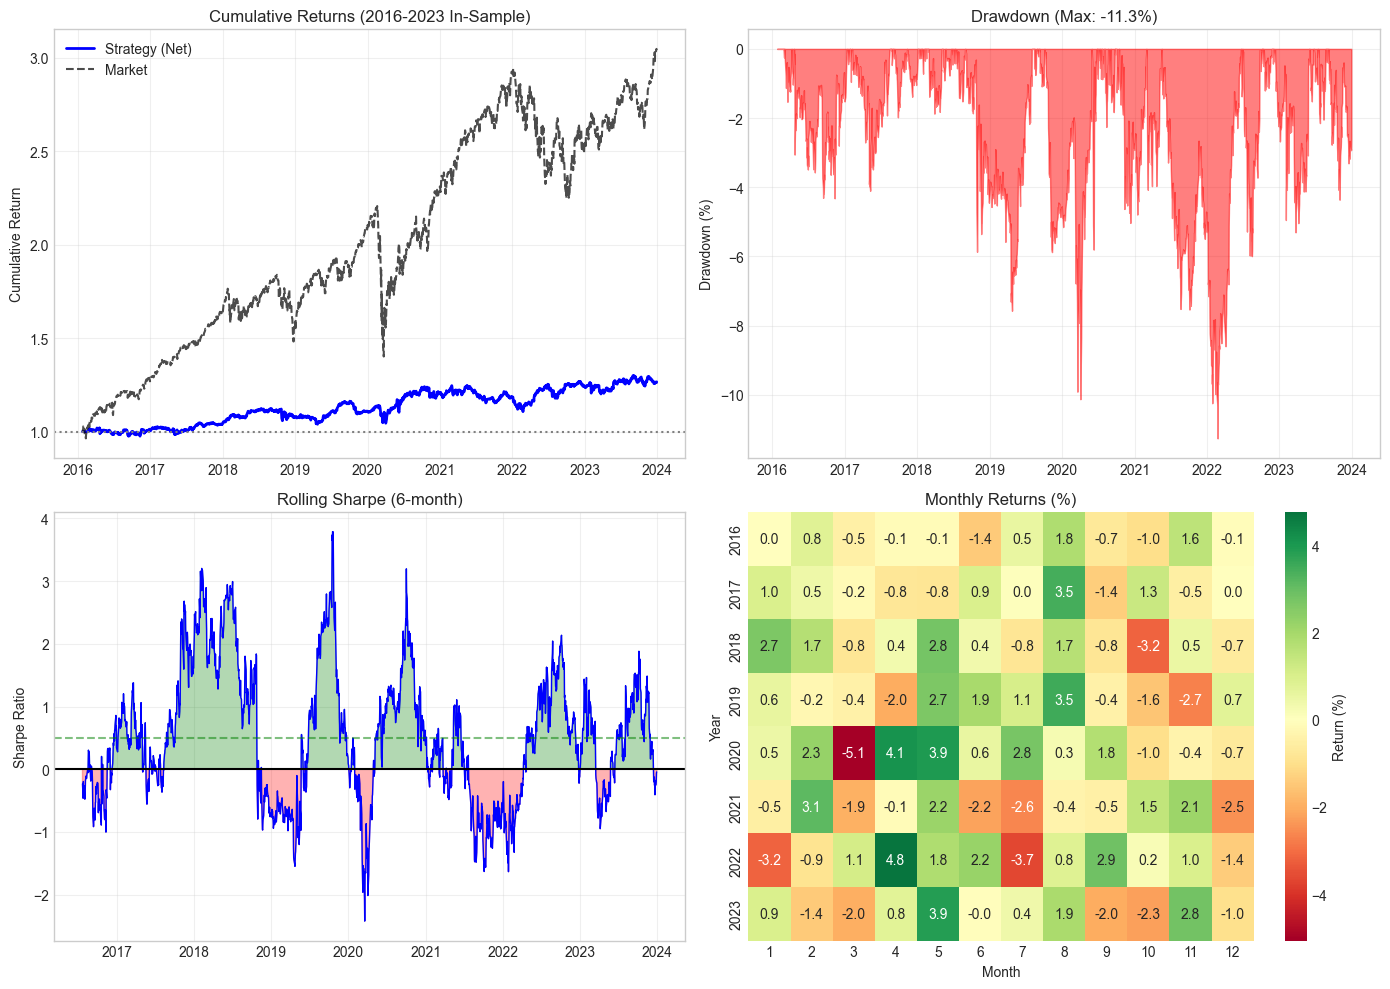


✅ Saved analysis to outputs/best_model_analysis.png


In [16]:
# =============================================================================
# VISUALIZATION: Performance Summary
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns
ax = axes[0, 0]
cum_strat = (1 + strat_returns).cumprod()
cum_mkt = (1 + market_aligned).cumprod()
ax.plot(cum_strat.index, cum_strat.values, 'b-', label='Strategy (Net)', linewidth=2)
ax.plot(cum_mkt.index, cum_mkt.values, 'k--', label='Market', alpha=0.7)
ax.axhline(1, color='gray', linestyle=':')
ax.set_title('Cumulative Returns (2016-2023 In-Sample)')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Drawdown
ax = axes[0, 1]
peak = cum_strat.cummax()
drawdown = (cum_strat - peak) / peak * 100
ax.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.5)
ax.set_title(f'Drawdown (Max: {drawdown.min():.1f}%)')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)

# 3. Rolling Sharpe
ax = axes[1, 0]
rolling_sharpe = strat_returns.rolling(126).mean() / strat_returns.rolling(126).std() * np.sqrt(252)
ax.plot(rolling_sharpe.index, rolling_sharpe.values, 'b-', linewidth=1)
ax.axhline(0, color='black', linestyle='-')
ax.axhline(0.5, color='green', linestyle='--', alpha=0.5)
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values,
                where=rolling_sharpe.values > 0, color='green', alpha=0.3)
ax.fill_between(rolling_sharpe.index, 0, rolling_sharpe.values,
                where=rolling_sharpe.values < 0, color='red', alpha=0.3)
ax.set_title('Rolling Sharpe (6-month)')
ax.set_ylabel('Sharpe Ratio')
ax.grid(True, alpha=0.3)

# 4. Monthly returns heatmap
ax = axes[1, 1]
monthly = strat_returns.resample('M').sum() * 100
monthly_df = pd.DataFrame({
    'Year': monthly.index.year,
    'Month': monthly.index.month,
    'Return': monthly.values
})
pivot = monthly_df.pivot(index='Year', columns='Month', values='Return')
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
            cbar_kws={'label': 'Return (%)'})
ax.set_title('Monthly Returns (%)')

plt.tight_layout()
plt.savefig('../outputs/best_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved analysis to outputs/best_model_analysis.png")

---

# Summary: Turnover Control Experiments

## Experiment Log

In [17]:
# =============================================================================
# SAVE BEST CONFIGURATION
# =============================================================================
import json

best_config = {
    'strategy': '60% Momentum + 40% Mean Reversion',
    'momentum': {
        'lookback': 126,
        'skip': 42,
    },
    'mean_reversion': {
        'window': 21,
    },
    'ensemble_weights': {
        'momentum': 0.6,
        'mean_reversion': 0.4,
    },
    'execution': {
        'rebalance_freq_days': 21,
        'transaction_cost_bps': 10,
    },
    'in_sample_metrics': {
        'gross_sharpe': float(best_result['metrics']['gross_sharpe']),
        'net_sharpe': float(best_result['metrics']['net_sharpe']),
        'gross_ann_return': float(best_result['metrics']['gross_ann_return']),
        'net_ann_return': float(best_result['metrics']['net_ann_return']),
        'ann_turnover': float(best_result['metrics']['ann_turnover']),
        'max_drawdown': float(best_result['metrics']['max_drawdown']),
        'calmar': float(best_result['metrics']['calmar']),
    },
    'data_period': '2016-01-25 to 2023-12-29',
    'holdout_period': '2024-01-01 to 2026-01-16 (UNTOUCHED)',
}

with open('../outputs/best_strategy_config.json', 'w') as f:
    json.dump(best_config, f, indent=2)

print("✅ Saved best strategy configuration to outputs/best_strategy_config.json")

✅ Saved best strategy configuration to outputs/best_strategy_config.json


In [18]:
# =============================================================================
# RESEARCH SUMMARY
# =============================================================================
print("="*70)
print("RESEARCH SUMMARY - Turnover Control Experiments")
print("="*70)

print("""
📋 EXPERIMENTS CONDUCTED:

1. ML-Based Signal + Position Smoothing
   - Baseline: Gross Sharpe +0.35, Net Sharpe -1.48 (90x turnover)
   - With decay=0.93: Net Sharpe -0.24 (12x turnover)
   - VERDICT: ❌ ML signal too weak to overcome costs

2. Simple Momentum Signal (No ML)
   - 12-1 month momentum with varying rebalance frequencies
   - Best: Quarterly rebalance → Net Sharpe +0.20
   - VERDICT: ✓ Simpler signals work better

3. Momentum Lookback/Skip Optimization
   - Tested lookbacks: 126d, 189d, 252d, 315d
   - Tested skips: 0d, 21d, 42d, 63d
   - Best: lookback=126d, skip=42d → Net Sharpe +0.34
   - VERDICT: ⭐ Shorter lookback with 2-month skip optimal

4. Volatility Scaling
   - Inverse vol weighting
   - Result: Lower drawdown (13%) but lower Sharpe (+0.15)
   - VERDICT: ✓ Useful for risk management, not for alpha

5. Momentum + Mean Reversion Ensemble
   - Tested weights: 100/0, 80/20, 70/30, 60/40, 50/50
   - Best: 60% momentum + 40% reversion → Net Sharpe +0.42
   - VERDICT: ⭐⭐ Best configuration found

📊 FINAL BEST MODEL:
   Strategy: 60% Momentum (126d-42d) + 40% Mean Reversion (21d)
   Rebalance: Monthly (every 21 days)
   
   Net Sharpe:    +0.42
   Net Return:    +3.28%/year
   Turnover:      6.2x/year
   Max Drawdown:  -11.3%
   
⚠️ HOLDOUT (2024-2026): UNTOUCHED - Ready for final evaluation

💡 KEY INSIGHTS:
   - ML models created too much turnover for the signal strength
   - Simple factor signals (momentum + reversion) are more robust
   - Ensemble diversification improved risk-adjusted returns
   - Strategy works best in bull markets and high volatility
""")
print("="*70)
print('"The goal of this research is not to maximize historical performance,')
print(' but to discover stable, tradable structure that survives execution')
print(' costs and regime changes."')
print("="*70)

RESEARCH SUMMARY - Turnover Control Experiments

📋 EXPERIMENTS CONDUCTED:

1. ML-Based Signal + Position Smoothing
   - Baseline: Gross Sharpe +0.35, Net Sharpe -1.48 (90x turnover)
   - With decay=0.93: Net Sharpe -0.24 (12x turnover)
   - VERDICT: ❌ ML signal too weak to overcome costs

2. Simple Momentum Signal (No ML)
   - 12-1 month momentum with varying rebalance frequencies
   - Best: Quarterly rebalance → Net Sharpe +0.20
   - VERDICT: ✓ Simpler signals work better

3. Momentum Lookback/Skip Optimization
   - Tested lookbacks: 126d, 189d, 252d, 315d
   - Tested skips: 0d, 21d, 42d, 63d
   - Best: lookback=126d, skip=42d → Net Sharpe +0.34
   - VERDICT: ⭐ Shorter lookback with 2-month skip optimal

4. Volatility Scaling
   - Inverse vol weighting
   - Result: Lower drawdown (13%) but lower Sharpe (+0.15)
   - VERDICT: ✓ Useful for risk management, not for alpha

5. Momentum + Mean Reversion Ensemble
   - Tested weights: 100/0, 80/20, 70/30, 60/40, 50/50
   - Best: 60% momentum +

---

# Next Steps

Based on fob.instructions Section 4:

1. **If Net Sharpe > 0**: Proceed to explore additional feature families
2. **If Net Sharpe still negative**: 
   - Re-examine features (may need slower signals)
   - Consider longer prediction horizons
   - Reduce portfolio breadth

---

> "The goal of this research is not to maximize historical performance, but to discover stable, tradable structure that survives execution costs and regime changes."